In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

from interpolate import get_latent_vector, slerp
from deepflow.utils import load_generator
from deepflow.plotting_utils import update_matplotlib_config, colorbar
update_matplotlib_config()
import torch
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import xarray as xr
import tifffile

import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter, MaxNLocator

Populating the interactive namespace from numpy and matplotlib


/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [8]:
plot=False

## Creating an interpolation animation between the three obtained MAP maxima

In [11]:
generator = load_generator("./checkpoints/generator_facies_multichannel_4_6790.pth")

z1_file = "./results/interpolations/run_1/iteration_233.nc"
z2_file = "./results/interpolations/run_4/iteration_253.nc"
z3_file = "./results/interpolations/run_5/iteration_475.nc"

z1 = get_latent_vector(z1_file)
z2 = get_latent_vector(z2_file)
z3 = get_latent_vector(z3_file)

vals = np.linspace(0, 1, 101)
print(vals)

z_int = [torch.from_numpy(slerp(val, z1, z2)).view(1, 50, 1, 2) for val in vals]+ \
         [torch.from_numpy(slerp(val, z2, z3)).view(1, 50, 1, 2) for val in vals] + \
         [torch.from_numpy(slerp(val, z3, z1)).view(1, 50, 1, 2) for val in vals] 

print(len(z_int))

ks = []
for i, z in enumerate(z_int):
    k, poro, x = generator(z)
    ks.append(k.detach().numpy())

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
303


In [12]:
tifffile.imsave("./results/animations/interpolated_1_4_5.tiff", np.array([k[0, 0].T for k in ks]).astype(np.float32))

## Plotting the resulting flow, well, and prior loss for interpolated latent vectors

In [4]:
def get_interpolations(folder, N=10):
    curves = []
    poros, perms = [], []
    misfits = []
    zs = []
    for i in range(0, N):
        try:
            ds = xr.open_dataset(folder+'/iteration_'+str(i)+'.nc')
            qo = ds['state_variables'][dict(state_variable=2, well=1)]*(-60*60*24)
            qw = ds['state_variables'][dict(state_variable=1, well=1)]*(-60*60*24)
            p = ds['state_variables'][dict(state_variable=0, well=0)]/1e5
            poros.append(ds['material_properties'][0].values)
            perms.append(ds['material_properties'][1].values)
            curves.append([qo, qw, p])
            zs.append(ds['latent_variables'].values[1])
            misfits.append([ds['misfit_value'].values])
            ds.close()
        except FileNotFoundError:
            print(i, " not found ")
    return np.array(curves), np.array(poros), np.array(perms), np.array(misfits), np.array(zs)

In [5]:
folders = ['./results/interpolations/interpolation_1_4/', './results/interpolations/interpolation_4_5/', './results/interpolations/interpolation_5_1/']
interpolated_data = [get_interpolations(folder, N=101)  for folder in folders]

In [6]:
total_loss = np.concatenate([data[3][:, 0, 0, [0, 1, 3]].sum(1) for data in interpolated_data], 0)
accuracies = np.concatenate([data[3][:, 0, 0, 2] for data in interpolated_data], 0)
flow_loss = np.concatenate([data[3][:, 0, 0, 0] for data in interpolated_data], 0)
well_loss = np.concatenate([data[3][:, 0, 0, 1] for data in interpolated_data], 0)
prior_loss = np.concatenate([data[3][:, 0, 0, 3] for data in interpolated_data], 0)
zs = np.concatenate([data[4] for data in interpolated_data], 0)

N_interpolations = len(zs)

In [13]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
def plot_interpolation_losses(host, run_names, flow_loss, well_loss, prior_loss, ranges=[[1.2, 1.4], [1e-1, 1e6], [1e-1, 1e6]]):
    fig = host.figure
    labels = ['']*303
    labels[0] = run_names[0]
    labels[100] = run_names[1]
    labels[201] = run_names[2]
    labels[302] = run_names[0]

    f = 16
    
    def format_fn(tick_val, tick_pos):
        if int(tick_val) in [0, 100, 201, 302]:
            return labels[int(tick_val)]
        else:
            return ''
    
    host.xaxis.set_ticks([-25, 0, 100, 201, 302, 325])
    host.xaxis.set_major_formatter(FuncFormatter(format_fn))
    
    par1 = host.twinx()
    par2 = host.twinx()

    par2.spines["right"].set_position(("axes", 1.1))
    make_patch_spines_invisible(par2)
    par2.spines["right"].set_visible(True)

    p1, = host.plot(flow_loss, color="black", linestyle="-.", label="Flow Loss")#, c=colors, s=1)
    host.set_ylabel("Flow Loss", fontsize=f)
    p2, = par1.plot(well_loss, color="red", linestyle="-", label="Well Loss")
    par1.set_ylabel("Well Loss", fontsize=f)
    p3, = par2.plot(prior_loss, color="blue", linestyle="--", label="Prior Loss")
    par2.set_ylabel("Prior Loss", fontsize=f)

    host.set_yscale("log")
    par1.set_yscale("log")
    host.set_xlabel("Interpolations", fontsize=16)
    par2.set_ylim(*ranges[0])
    host.set_ylim(*ranges[1])
    par1.set_ylim(*ranges[2])

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p1.get_color())

    tkw = dict(size=4, width=1.05)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p1.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    host.scatter([0, 100, 201, 302], flow_loss[[0, 100, 201, 302]], marker="o", s=50, color="black")
    par1.scatter([0, 100, 201, 302], well_loss[[0, 100, 201, 302]], marker="o", s=50, color="black")
    par2.scatter([0, 100, 201, 302], prior_loss[[0, 100, 201, 302]], marker="o", s=50, color="black")

    lines = [p1, p2, p3]
    host.legend(lines, [l.get_label() for l in lines], fontsize=14, loc=3)
    
    return None

def plot_interpolation_total_loss(host, total_loss, accuracies):
    fig = host.figure
    labels = ['']*303
    labels[0] = run_names[0]
    labels[100] = run_names[1]
    labels[201] = run_names[2]
    labels[302] = run_names[0]
    
    f = 16
    
    def format_fn(tick_val, tick_pos):
        if int(tick_val) in [0, 100, 201, 302]:
            return labels[int(tick_val)]
        else:
            return ''
        
    host.xaxis.set_ticks([-25, 0, 100, 201, 302, 325])
    host.xaxis.set_major_formatter(FuncFormatter(format_fn))
        
    par1 = host.twinx()

    p1, = host.plot(total_loss, color="black", linestyle="-.", label="Total Loss")#, c=colors, s=1)
    host.set_ylabel("Total Loss", fontsize=f)
    p2, = par1.plot(accuracies, color="red", linestyle="-", label="Well Acc.")
    par1.set_ylabel("Well Accuracy", fontsize=f)

    host.set_yscale("log")
    host.set_xlabel("Interpolations", fontsize=16)
    par1.set_ylim(0.8, 1.01)
    host.set_ylim(1e-1, 1e6)

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p1.get_color())

    tkw = dict(size=4, width=1.05)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p1.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    host.scatter([0, 100, 201, 302], total_loss[[0, 100, 201, 302]], marker="o", s=50, color="black")
    par1.scatter([0, 100, 201, 302], accuracies[[0, 100, 201, 302]], marker="o", s=50, color="black")
    
    lines = [p1, p2]#, p3]
    host.legend(lines, [l.get_label() for l in lines], fontsize=14, loc=3)


    return None

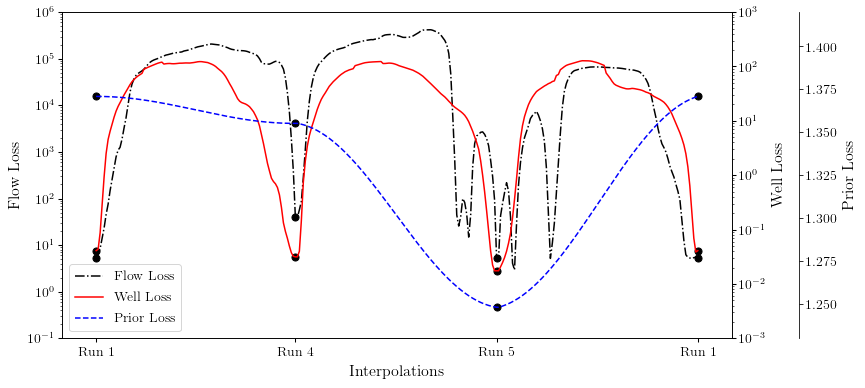

In [14]:
run_names = ['Run 1', 'Run 4', 'Run 5']
fig, axarr = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(right=0.9)
plot_interpolation_losses(axarr, run_names, flow_loss[:303], well_loss[:303], prior_loss[:303],
                         [[1.23, 1.42], [1e-1, 1e6], [1e-3, 1e3]])

if plot:
    plt.savefig("./results/figures/interpolation_losses_1_4_5_1.png", dpi=300, bbox_inches="tight")

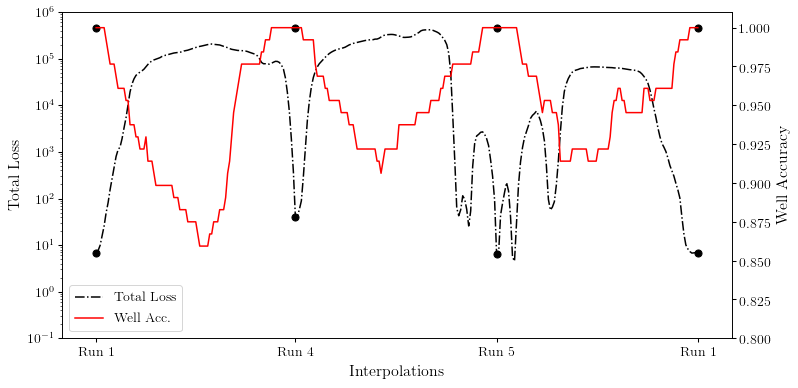

In [15]:
fig, axarr = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(right=0.9)

plot_interpolation_total_loss(axarr, total_loss[0:303], accuracies[0:303])

if plot:
    plt.savefig("./results/figures/interpolation_total_loss_1_4_5_1.png", dpi=300, bbox_inches="tight")